In [1]:
import h5py
import matplotlib.pyplot as plt
from collections import Counter
from data import Vocabulary
import numpy as np
from tqdm import tqdm
import pandas
import re

# Pretraining Data

In [2]:
f = open("data/books_large.txt")
data = f.readlines()

In [3]:
counter = Counter()
for d in data:
    counter[len(d.split())] += 1

Sentences longer than 100 tokens: 11113


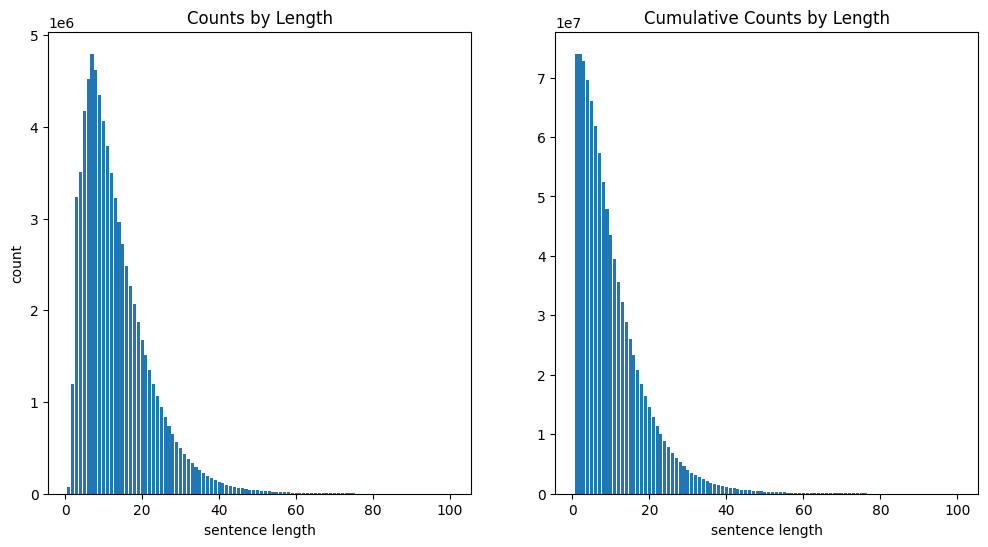

In [4]:
sorted_items = sorted(counter.items(), key=lambda x: x[0])
lengths, counts = zip(*sorted_items)
sums = [sum(counts[i:]) for i in range(len(lengths))]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].bar(lengths[:100], counts[:100])
axs[0].set_title("Counts by Length")
axs[0].set_xlabel("sentence length")
axs[0].set_ylabel("count")

axs[1].bar(lengths[:100], sums[:100])
axs[1].set_title("Cumulative Counts by Length")
axs[1].set_xlabel("sentence length")

print(f"Sentences longer than 100 tokens: {sum(counts[100:])}")

In [5]:
min_seq_len = 5
max_seq_len = 100

valid_size = 1e5
test_size = 1e5

vocab = Vocabulary.load("data/vocab.json")
indices = np.arange(len(data))
np.random.shuffle(indices)

with h5py.File("data/pretraining_split.h5", "w") as h5f:
    dt = h5py.special_dtype(vlen=int)
    valid_ds = h5f.create_dataset("validation", shape=(valid_size,), dtype=dt, chunks=True)
    test_ds = h5f.create_dataset("test", shape=(test_size,), dtype=dt, chunks=True)
    training_ds = h5f.create_dataset("training", shape=(len(data) - valid_size - test_size,), dtype=dt, chunks=True, maxshape=(None,))
    
    count_valid = count_test = count_train  = 0
    for idx in tqdm(indices):
        wrd_indices = vocab.words_to_indices(data[idx].split())
        
        if len(wrd_indices) < min_seq_len or len(wrd_indices) > max_seq_len:
            continue

        if count_valid < valid_size:
            valid_ds[count_valid] = wrd_indices
            count_valid += 1
        elif count_test < test_size:
            test_ds[count_test] = wrd_indices
            count_test += 1
        else:
            training_ds[count_train] = wrd_indices
            count_train += 1
    
    training_ds.resize((count_train,)) # since we filtered out some sentences, resize to the actual size

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 74004228/74004228 [1:30:24<00:00, 13641.36it/s]


### UNK Ratio

In [28]:
with h5py.File("data/pretraining_split.h5", "r") as h5f:
    valid_ds = h5f["validation"]
    unk_index = vocab.word_to_index[vocab.unk_token]
    total_unk = 0
    total = 0
    for wrd_indices in valid_ds:
        total_unk += sum(wrd_indices==unk_index)
        total += len(wrd_indices)
    print(f"Total tokens: {total}")
    print(f"UNK tokens: {total_unk}")
    print(f"Ratio: {round(total_unk/total*100, 4)}%")

Total tokens: 1450196
UNK tokens: 22857
Ratio: 1.5761%


# Finetuning Data|

In [3]:
train_ds = pandas.read_csv("data/emotion_dataset_new_train.csv")
eval_ds = pandas.read_csv("data/emotion_dataset_new_eval.csv")
vocab = Vocabulary.load("data/vocab2.json")

Anger       0.160263
Fear        0.129352
Joy         0.357197
Sadness     0.313231
Surprise    0.046307
dtype: float64
Anger        6.239744
Fear         7.730829
Joy          2.799575
Sadness      3.192531
Surprise    21.594953
dtype: float64


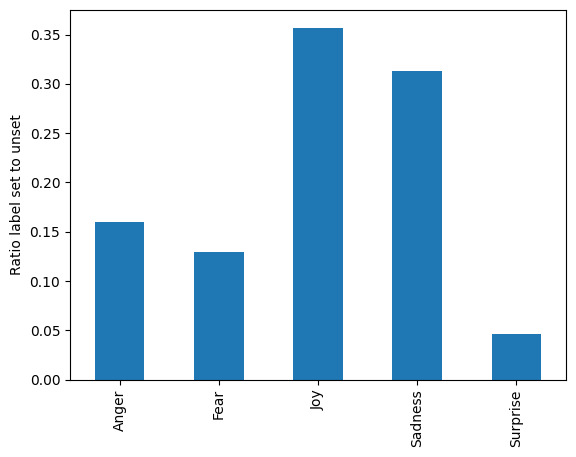

In [4]:
label_counts = train_ds[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']].sum()
ratios = label_counts/ len(train_ds)
ratios.plot(kind="bar")
plt.ylabel('Ratio label set to unset')
print(ratios)
print(1/ratios)  # pos_weights

In [5]:
def process_str(x: str) -> list[str]:
    x = x.lower()
    x = re.sub(r'([.,!?()"\'])', r' \1 ', x) # add whitespace around punctuation
    return x.split()

In [6]:
def prepare_data(df):
    features = df['text'].apply(lambda x: np.array(vocab.words_to_indices(process_str(x)), dtype=np.int32)).to_list()
    labels = df[['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']].to_numpy(dtype=np.int32)
    return features, labels

train_features, train_labels = prepare_data(train_ds)
eval_features, eval_labels = prepare_data(eval_ds)


In [7]:
with h5py.File("data/finetuning_split.h5", "w") as h5f:
    compound_dtype = np.dtype([('feature', h5py.special_dtype(vlen=int)),
                               ('label', np.int32, (5,))])
    
    train_data = np.array([(f, l) for f, l in zip(train_features, train_labels)], dtype=compound_dtype)
    eval_data = np.array([(f, l) for f, l in zip(eval_features, eval_labels)], dtype=compound_dtype)
    
    valid_ds = h5f.create_dataset("validation", data=eval_data, chunks=True)
    train_ds = h5f.create_dataset("training", data=train_data, chunks=True)

### UNK Ratio

In [8]:
def calculate_unk_ratio(h5_path, vocab):
    with h5py.File(h5_path, "r") as h5f:
        training_data = h5f["training"]
        unk_index = vocab.word_to_index[vocab.unk_token]
        total_unk = 0
        total = 0
        for wrd_indices, _ in training_data:
            total_unk += sum(wrd_indices==unk_index)
            total += len(wrd_indices)
        print(f"Total tokens: {total}")
        print(f"UNK tokens: {total_unk}")
        print(f"Ratio: {round(total_unk/total*100, 4)}%")

In [9]:
calculate_unk_ratio("data/finetuning_split.h5", vocab)

Total tokens: 5093090
UNK tokens: 122692
Ratio: 2.409%


### sentiment140

In [2]:
df = pandas.read_csv("data/sentiment140.csv", encoding="ISO-8859-1", delimiter=",")

In [3]:
print(df.keys())

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')


In [4]:
def process_str(x: str) -> list[str]:
    x = x.lower()
    x = re.sub(r'(https?://\S+|www\.\S+)', '<URL>', x)
    x = re.sub(r'@\w+','<USERNAME>', x)
    x = re.sub(r'([.,:;!?()"\'])', r' \1 ', x) # add whitespace around punctuation
    return x.split()

In [5]:
vocab = Vocabulary(extra_tokens=["<LABEL_MASK>"])

In [6]:
texts = [process_str(s)+[("<NEGATIVE>" if t==0 else "<POSITIVE>")] for s, t in zip(df["text"], df["target"])]
vocab.build(texts, vocab_size=30000)
print(texts[0])

['<USERNAME>', '<URL>', '-', 'awww', ',', 'that', "'", 's', 'a', 'bummer', '.', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', '.', ';', 'd', '<NEGATIVE>']


In [7]:
text_ids = [vocab.words_to_indices(s) for s in texts]

In [8]:
max([len(x) for x in texts])

230

In [9]:
count_training = len(text_ids)-100000
count_valid = 100000
training_indices = np.arange(0, count_training)
valid_indices = np.arange(0, count_valid)

np.random.shuffle(training_indices)
np.random.shuffle(valid_indices)
training_data = [text_ids[idx] for idx in training_indices]
valid_data = [text_ids[idx] for idx in valid_indices]

In [10]:
with h5py.File("data/sentiment140.h5", "w") as h5f:
    dt = h5py.special_dtype(vlen=int)

    training_ds = h5f.create_dataset("training", shape=(len(training_data),), chunks=True, dtype=dt)
    valid_ds = h5f.create_dataset("validation", shape=(len(valid_data),), chunks=True, dtype=dt)

    training_ds[:] = training_data
    valid_ds[:] = valid_data

In [11]:

with h5py.File("data/sentiment140.h5", "r") as h5f:
    training_data = h5f["training"]
    unk_index = vocab.word_to_index[vocab.unk_token]
    total_unk = 0
    total = 0
    for wrd_indices in training_data:
        total_unk += sum(wrd_indices==unk_index)
        total += len(wrd_indices)
    print(f"Total tokens: {total}")
    print(f"UNK tokens: {total_unk}")
    print(f"Ratio: {round(total_unk/total*100, 4)}%")

Total tokens: 26353084
UNK tokens: 586413
Ratio: 2.2252%


In [12]:
print(texts[5])
print(a:=vocab.words_to_indices(texts[5]))
print(vocab.index_to_words(a))

['<USERNAME>', 'not', 'the', 'whole', 'crew', '<NEGATIVE>']
[9, 38, 12, 446, 2220, 7]
['<USERNAME>', 'not', 'the', 'whole', 'crew', '<NEGATIVE>']


In [13]:
vocab.save("data/vocab2.json")

# Finetune data 2